In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt 

%matplotlib inline

In [15]:
hdr_folder = "HDR"
image_filenames = [
    "StLouisArchMultExpCDR.jpg",
    "StLouisArchMultExpEV+1.51.jpg",
    "StLouisArchMultExpEV+4.09.jpg",
    "StLouisArchMultExpEV-1.82.jpg",
    "StLouisArchMultExpEV-4.72.jpg"
]

In [16]:
def load_images_from_folder(folder, filenames):
    loaded_images = []
    loaded_paths = []
    print(f"Attempting to read images from folder: {folder}")
    if not os.path.isdir(folder):
        print(f"Error: Folder '{folder}' not found.")
        return [], [] 
        
    for filename in filenames:
        path = os.path.join(folder, filename)
        if os.path.exists(path):
            img = cv2.imread(path)
            if img is not None:
                loaded_images.append(img.astype(np.float32)) 
                loaded_paths.append(path)
                print(f"Loaded {os.path.basename(path)}, shape: {img.shape}, dtype: {loaded_images[-1].dtype}")
            else:
                print(f"Error reading image: {path}")
        else:
            print(f"Warning: Image '{path}' not found. It will be skipped.")
    
    if not loaded_images:
        print("Function 'load_images_from_folder' did not load any images.")
    return loaded_images, loaded_paths

print("Image loading function defined.")

Image loading function defined.


In [17]:
print("loading images...")
if not os.path.isdir(hdr_folder):
    print(f"Error: Folder '{hdr_folder}' not found. Cannot load images.")
    images_float = [] 
    loaded_image_paths_part_b = []
else:
    images_float, loaded_image_paths_part_b = load_images_from_folder(hdr_folder, image_filenames)

if not images_float:
    print("image error")
else:
    print(f"\nSuccessfully loaded {len(images_float)}")

    first_shape_b = images_float[0].shape
    consistent_shapes_b = True
    for i, img in enumerate(images_float[1:], 1):
        if img.shape != first_shape_b:
            print(f"Error: Image {os.path.basename(loaded_image_paths_part_b[i])} has shape {img.shape}, expected {first_shape_b}.")
            consistent_shapes_b = False
            break
    if not consistent_shapes_b:
        print("Image shapes are inconsistent")



loading images...
Attempting to read images from folder: HDR
Loaded StLouisArchMultExpCDR.jpg, shape: (2112, 2816, 3), dtype: float32
Loaded StLouisArchMultExpEV+1.51.jpg, shape: (2112, 2816, 3), dtype: float32
Loaded StLouisArchMultExpEV+4.09.jpg, shape: (2112, 2816, 3), dtype: float32
Loaded StLouisArchMultExpEV-1.82.jpg, shape: (2112, 2816, 3), dtype: float32
Loaded StLouisArchMultExpEV-4.72.jpg, shape: (2112, 2816, 3), dtype: float32

Successfully loaded 5


In [18]:
average_image_part_a_uint8 = None


first_shape_a_recalc = images_float[0].shape
consistent_shapes_a_recalc = True
for img in images_float[1:]:
    if img.shape != first_shape_a_recalc:
        consistent_shapes_a_recalc = False
        break
            
if consistent_shapes_a_recalc:
    sum_image_part_a = np.zeros_like(images_float[0], dtype=np.float32)
    for img in images_float:
        sum_image_part_a += img
    average_image_float_part_a = sum_image_part_a / len(images_float)
    average_image_part_a_uint8 = np.clip(average_image_float_part_a, 0, 255).astype(np.uint8)
    print("Recalculated average image for Part A comparison.")
else:
    print("Error in getting average.")


if average_image_part_a_uint8 is not None:
    print(f"Part A average image ready for comparison (shape: {average_image_part_a_uint8.shape}).")


Recalculated average image for Part A comparison.
Part A average image ready for comparison (shape: (2112, 2816, 3)).


In [19]:
coeffs_list_per_image = []
wavelet = 'haar'

if images_float and ('consistent_shapes_b' in globals() and consistent_shapes_b):
    print(f"\n--- Starting Part (B): Wavelet")
    print(f"\n1. Decomposing images using '{wavelet}' wavelet...")
    
    for i, img_float in enumerate(images_float):
        img_coeffs_channels = []
        for channel_idx in range(img_float.shape[2]): 
            channel_data = img_float[:, :, channel_idx]
          
            coeffs = pywt.dwt2(channel_data, wavelet, mode='periodization') 
            img_coeffs_channels.append(coeffs)
        coeffs_list_per_image.append(img_coeffs_channels)
        print(f"Decomposed image {os.path.basename(loaded_image_paths_part_b[i])} ({i+1}/{len(images_float)})")
    
    if coeffs_list_per_image:
        print("Decomposition complete for all images.")

elif not images_float:
    print("Skipping Wavelet Decomposition: No images loaded.")



--- Starting Part (B): Wavelet

1. Decomposing images using 'haar' wavelet...
Decomposed image StLouisArchMultExpCDR.jpg (1/5)
Decomposed image StLouisArchMultExpEV+1.51.jpg (2/5)
Decomposed image StLouisArchMultExpEV+4.09.jpg (3/5)
Decomposed image StLouisArchMultExpEV-1.82.jpg (4/5)
Decomposed image StLouisArchMultExpEV-4.72.jpg (5/5)
Decomposition complete for all images.


In [20]:
fused_coeffs_all_channels = []

if coeffs_list_per_image: 
    print("\n2. Fusing coefficients...")
    num_images_b = len(images_float)
    num_channels_b = images_float[0].shape[2]

    for channel_idx in range(num_channels_b):
        ll_coeffs_channel, lh_coeffs_channel, hl_coeffs_channel, hh_coeffs_channel = [], [], [], []

        for img_idx in range(num_images_b):
            LL, (LH, HL, HH) = coeffs_list_per_image[img_idx][channel_idx]
            ll_coeffs_channel.append(LL)
            lh_coeffs_channel.append(LH)
            hl_coeffs_channel.append(HL)
            hh_coeffs_channel.append(HH)

        
        stacked_ll = np.stack(ll_coeffs_channel, axis=0)
        stacked_lh = np.stack(lh_coeffs_channel, axis=0)
        stacked_hl = np.stack(hl_coeffs_channel, axis=0)
        stacked_hh = np.stack(hh_coeffs_channel, axis=0)

       
        fused_ll = np.mean(stacked_ll, axis=0)
        

        fused_lh = np.max(stacked_lh, axis=0) 
        fused_hl = np.max(stacked_hl, axis=0) 
        fused_hh = np.max(stacked_hh, axis=0) 
        
        fused_coeffs_all_channels.append((fused_ll, (fused_lh, fused_hl, fused_hh)))
        print(f"  Fused coefficients for channel {channel_idx} (B,G,R order).")
    
    if fused_coeffs_all_channels:
        print("Coefficient fusion complete.")
        


2. Fusing coefficients...
  Fused coefficients for channel 0 (B,G,R order).
  Fused coefficients for channel 1 (B,G,R order).
  Fused coefficients for channel 2 (B,G,R order).
Coefficient fusion complete.


In [21]:
fused_image_wavelet_uint8 = None 

if fused_coeffs_all_channels:
    print("\n3. Reconstructing image from fused coefficients...")
    reconstructed_channels = []
    num_channels_b = images_float[0].shape[2] 

    for channel_idx in range(num_channels_b):
        coeffs_to_reconstruct = fused_coeffs_all_channels[channel_idx]
        reconstructed_channel = pywt.idwt2(coeffs_to_reconstruct, wavelet, mode='periodization')
        
        original_channel_shape = images_float[0][:,:,channel_idx].shape
        reconstructed_channel = reconstructed_channel[:original_channel_shape[0], :original_channel_shape[1]]
        
        reconstructed_channels.append(reconstructed_channel)
        print(f"  Reconstructed channel {channel_idx}.")

    if reconstructed_channels and len(reconstructed_channels) == num_channels_b:
        fused_image_wavelet_float = cv2.merge(reconstructed_channels)
        fused_image_wavelet_uint8 = np.clip(fused_image_wavelet_float, 0, 255).astype(np.uint8)
        print(f"Wavelet fusion and reconstruction complete. Result shape: {fused_image_wavelet_uint8.shape}")



3. Reconstructing image from fused coefficients...
  Reconstructed channel 0.
  Reconstructed channel 1.
  Reconstructed channel 2.
Wavelet fusion and reconstruction complete. Result shape: (2112, 2816, 3)



4. Displaying results...


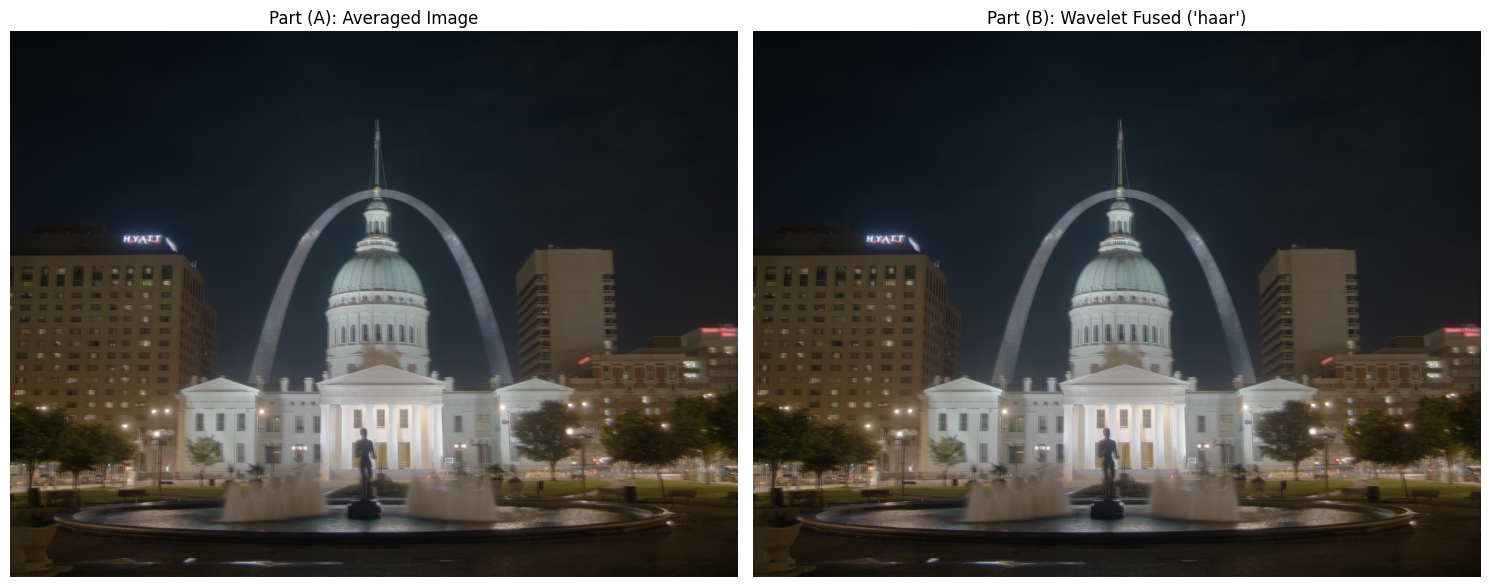

In [22]:
if fused_image_wavelet_uint8 is not None:
    print("\n4. Displaying results...")
    
    num_plots = 0
    if average_image_part_a_uint8 is not None:
        num_plots += 1
    if fused_image_wavelet_uint8 is not None:
        num_plots +=1

    if num_plots == 0:
        print("No images available to display.")
    else:
        plt.figure(figsize=(5 * num_plots + 5, 7)) 
        current_plot = 1

        if average_image_part_a_uint8 is not None:
            plt.subplot(1, num_plots, current_plot)
            plt.imshow(cv2.cvtColor(average_image_part_a_uint8, cv2.COLOR_BGR2RGB))
            plt.title("Part (A): Averaged Image")
            plt.axis('off')
            current_plot += 1


        if fused_image_wavelet_uint8 is not None: 
            plt.subplot(1, num_plots, current_plot)
            plt.imshow(cv2.cvtColor(fused_image_wavelet_uint8, cv2.COLOR_BGR2RGB))
            plt.title(f"Part (B): Wavelet Fused ('{wavelet}')")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [23]:
if fused_image_wavelet_uint8 is not None:
    output_filename_wavelet = "StLouisArch_WaveletFused.png"
    try:
        cv2.imwrite(output_filename_wavelet, fused_image_wavelet_uint8)
        print(f"\nWavelet-fused image saved as {output_filename_wavelet}")
    except Exception as e:
        print(f"Error saving wavelet-fused image {output_filename_wavelet}: {e}")



Wavelet-fused image saved as StLouisArch_WaveletFused.png
